<a href="https://colab.research.google.com/github/BoboSamson/BoboSamson/blob/main/STL10_dataset_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(44)

cuda


Using Python version: sys.version_info(major=3, minor=11, micro=11, releaselevel='final', serial=0)


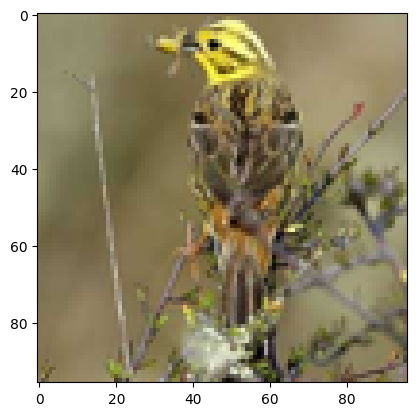

Streaming output truncated to the last 5000 lines.
Saving /content/sample_data/stl10_binary/img/2/0
Saving /content/sample_data/stl10_binary/img/6/1
Saving /content/sample_data/stl10_binary/img/2/2
Saving /content/sample_data/stl10_binary/img/7/3
Saving /content/sample_data/stl10_binary/img/4/4
Saving /content/sample_data/stl10_binary/img/10/5
Saving /content/sample_data/stl10_binary/img/8/6
Saving /content/sample_data/stl10_binary/img/5/7
Saving /content/sample_data/stl10_binary/img/6/8
Saving /content/sample_data/stl10_binary/img/9/9
Saving /content/sample_data/stl10_binary/img/1/10
Saving /content/sample_data/stl10_binary/img/7/11
Saving /content/sample_data/stl10_binary/img/1/12
Saving /content/sample_data/stl10_binary/img/9/13
Saving /content/sample_data/stl10_binary/img/8/14
Saving /content/sample_data/stl10_binary/img/7/15
Saving /content/sample_data/stl10_binary/img/5/16
Saving /content/sample_data/stl10_binary/img/7/17
Saving /content/sample_data/stl10_binary/img/3/18
Saving /

In [4]:
from __future__ import print_function

import os
import numpy as np
import matplotlib.pyplot as plt
import sys

try:
    from imageio import imsave
except ImportError:
    from scipy.misc import imsave

print("Using Python version:", sys.version_info)

# Image shape
HEIGHT = 96
WIDTH = 96
DEPTH = 3

# Size of a single image in bytes
SIZE = HEIGHT * WIDTH * DEPTH

# Local paths
DATA_DIR = "/content/sample_data/stl10_binary"
DATA_PATH = os.path.join(DATA_DIR, "/content/sample_data/stl10_binary/train_X.bin")
DATA_PATH_TEST = os.path.join(DATA_DIR, "/content/sample_data/stl10_binary/test_X.bin")
LABEL_PATH = os.path.join(DATA_DIR, "/content/sample_data/stl10_binary/train_y.bin")
LABEL_PATH_TEST = os.path.join(DATA_DIR, "/content/sample_data/stl10_binary/test_y.bin")

def read_labels(path_to_labels):
    """ Reads labels from binary file """
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels

def read_all_images(path_to_data):
    """ Reads all images from binary file """
    with open(path_to_data, 'rb') as f:
        everything = np.fromfile(f, dtype=np.uint8)
        images = np.reshape(everything, (-1, 3, 96, 96))
        images = np.transpose(images, (0, 3, 2, 1))
        return images

def read_single_image(image_file):
    """ Reads a single image from binary file """
    image = np.fromfile(image_file, dtype=np.uint8, count=SIZE)
    image = np.reshape(image, (3, 96, 96))
    image = np.transpose(image, (2, 1, 0))
    return image

def plot_image(image):
    """ Plots an image """
    plt.imshow(image)
    plt.show()

def save_image(image, name):
    """ Saves an image to disk """
    imsave(f"{name}.png", image, format="png")

def save_images(images, labels):
    """ Saves all images to disk with label-based directories """
    print("Saving images to disk")
    for i, image in enumerate(images):
        label = labels[i]
        directory = os.path.join(DATA_DIR, "img", str(label))
        os.makedirs(directory, exist_ok=True)
        filename = os.path.join(directory, str(i))
        print(f"Saving {filename}")
        save_image(image, filename)

if __name__ == "__main__":
    # Test reading a single image
    with open(DATA_PATH, "rb") as f:
        image = read_single_image(f)
        plot_image(image)

    # Read all images and labels
images = read_all_images(DATA_PATH)
print("Image data shape:", images.shape)

labels = read_labels(LABEL_PATH)
print("Labels shape:", labels.shape)

# Read test images and labels
images_test = read_all_images(DATA_PATH_TEST)
print("Test_images data shape:", images_test.shape)

labels_test = read_labels(LABEL_PATH_TEST)
print("Test_labels shape:", labels_test.shape)

# Save images to disk
save_images(images, labels)


In [5]:
#Step 2 Define Data Class
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class STL10Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        images: numpy array of shape (num_samples, 96, 96, 3)
        labels: numpy array of shape (num_samples,)
        transform: torchvision.transforms to apply to images
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]  # Get image
        label = self.labels[idx] - 1  # STL-10 labels are 1-indexed, convert to 0-indexed

        image = Image.fromarray(image)  # Convert NumPy array to PIL image

        if self.transform:
            image = self.transform(image)  # Apply transformations

        return image, label


In [6]:
# Step 3 Define transforms
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [7]:
#Step 4 Load Dataset
# Load images and labels (you will need to define the functions for loading data)
X_train = read_all_images(DATA_PATH)  # Shape: (5000, 96, 96, 3)
y_train = read_labels(LABEL_PATH)  # Shape: (5000,)

X_test = read_all_images(DATA_PATH_TEST)  # Shape: (8000, 96, 96, 3)
y_test = read_labels(LABEL_PATH_TEST)  # Shape: (8000,)

# Create PyTorch datasets
train_dataset = STL10Dataset(X_train, y_train, transform=train_transform)
test_dataset = STL10Dataset(X_test, y_test, transform=test_transform)


In [8]:
#Step 5 Create Dataloader
from torch.utils.data import DataLoader

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check DataLoader info
print(f"Length of train DataLoader: {len(train_dataloader)} batches")
print(f"Length of test DataLoader: {len(test_dataloader)} batches")

# Check if DataLoader is returning correct values
for batch in train_dataloader:
    print(f"Batch size: {len(batch)}")  # Should print 2 (images, labels)
    print(f"Image batch shape: {batch[0].shape}")  # Should be (32, 3, 96, 96)
    print(f"Label batch shape: {batch[1].shape}")  # Should be (32,)
    break


Length of train DataLoader: 157 batches
Length of test DataLoader: 250 batches
Batch size: 2
Image batch shape: torch.Size([32, 3, 96, 96])
Label batch shape: torch.Size([32])


In [9]:
#Step 6 Define baselie model model
import torch.nn as nn
import torch.nn.functional as F

class DeepCNN_BN_Dropout(nn.Module):
    def __init__(self, num_classes=10):
        super(DeepCNN_BN_Dropout, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # BatchNorm after conv1
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # BatchNorm after conv2

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)  # BatchNorm after conv3

        self.fc1 = nn.Linear(128 * 12 * 12, 256)
        self.bn_fc1 = nn.BatchNorm1d(256)  # BatchNorm for fully connected layer
        self.dropout1 = nn.Dropout(p=0.5)  # Dropout with 50% chance

        self.fc2 = nn.Linear(256, 128)
        self.bn_fc2 = nn.BatchNorm1d(128)  # BatchNorm for fully connected layer
        self.dropout2 = nn.Dropout(p=0.5)  # Dropout with 50% chance

        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Conv1 → BN → ReLU → Pool
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Conv2 → BN → ReLU → Pool
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # Conv3 → BN → ReLU → Pool

        x = torch.flatten(x, start_dim=1)

        x = F.relu(self.bn_fc1(self.fc1(x)))  # FC1 → BN → ReLU
        x = self.dropout1(x)  # Apply dropout after FC1

        x = F.relu(self.bn_fc2(self.fc2(x)))  # FC2 → BN → ReLU
        x = self.dropout2(x)  # Apply dropout after FC2

        x = self.fc3(x)  # No activation for final output (CrossEntropyLoss applies Softmax)

        return x


# model instance
model = DeepCNN_BN_Dropout(num_classes=10)


In [10]:
#Step 7 Set Device, loss function
import torch.optim as optim

# Set device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # L2 regularization


# Learning rate scheduler (optional)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


In [11]:
#Step 8 , set epochs and train
torch.manual_seed(44)
num_epochs = 20

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Reset gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)  # Get predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_dataloader):.4f}, Train Acc: {train_acc:.2f}%")

    scheduler.step()  # Adjust learning rate

print("Training complete!")


Epoch [1/20], Loss: 1.8435, Train Acc: 31.48%
Epoch [2/20], Loss: 1.4964, Train Acc: 43.56%
Epoch [3/20], Loss: 1.3533, Train Acc: 51.52%
Epoch [4/20], Loss: 1.2573, Train Acc: 53.66%
Epoch [5/20], Loss: 1.1674, Train Acc: 57.82%
Epoch [6/20], Loss: 1.0598, Train Acc: 61.68%
Epoch [7/20], Loss: 0.9977, Train Acc: 64.16%
Epoch [8/20], Loss: 0.9605, Train Acc: 65.94%
Epoch [9/20], Loss: 0.9415, Train Acc: 66.42%
Epoch [10/20], Loss: 0.8872, Train Acc: 68.22%
Epoch [11/20], Loss: 0.8139, Train Acc: 71.22%
Epoch [12/20], Loss: 0.7968, Train Acc: 71.84%
Epoch [13/20], Loss: 0.7705, Train Acc: 73.54%
Epoch [14/20], Loss: 0.7445, Train Acc: 74.06%
Epoch [15/20], Loss: 0.6986, Train Acc: 75.46%
Epoch [16/20], Loss: 0.6658, Train Acc: 77.14%
Epoch [17/20], Loss: 0.6719, Train Acc: 76.42%
Epoch [18/20], Loss: 0.6337, Train Acc: 78.92%
Epoch [19/20], Loss: 0.6099, Train Acc: 79.52%
Epoch [20/20], Loss: 0.6071, Train Acc: 79.02%
Training complete!


In [12]:
#Step 9 Save model
torch.save(model.state_dict(), "model.pth")


In [13]:
#Step 10 Evaluate model
import os
if not os.path.exists("model.pth"):
    print("Error: Model file 'model.pth' not found. Please train and save the model first.")
else:
    model_instance = DeepCNN_BN_Dropout().to(device)
    model_instance.load_state_dict(torch.load("model.pth", map_location=device))
    model_instance.eval()

    # Define evaluation function
    def accuracy_fn(y_true, y_pred):
        correct = (y_pred == y_true).sum().item()
        total = len(y_true)
        return (correct / total) * 100

    def eval_model(model: torch.nn.Module, data_loader, loss_fn, accuracy_fn, device):
        loss, acc = 0.0, 0.0
        model.eval()

        with torch.no_grad():
            for X, y in data_loader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                loss += loss_fn(y_pred, y).item()
                acc += accuracy_fn(y, y_pred.argmax(dim=1))

            loss /= len(data_loader)
            acc /= len(data_loader)

        return {"model_loss": loss, "model_acc": acc}

    # Test the model
    DeepCNN_BN_Dropout_results = eval_model(model=model_instance, data_loader=test_dataloader, loss_fn=criterion, accuracy_fn=accuracy_fn, device=device)
    print(DeepCNN_BN_Dropout_results)


{'model_loss': 0.7757365063428879, 'model_acc': 72.8125}


MODEL COMPARISON WITH deepCNN_BN_dropout2

In [14]:
from torch.utils.data import random_split, DataLoader

# Define the split ratio (e.g., 20% for validation, 80% for testing)
val_size = int(0.2 * len(test_dataset))  # 20% of test data for validation
test_size = len(test_dataset) - val_size  # Remaining for actual test set

# Split test dataset into validation and test datasets
val_dataset, test_dataset = random_split(test_dataset, [val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}")


Train size: 5000, Validation size: 1600, Test size: 6400


In [15]:


# Check DataLoader info
print(f"Length of train DataLoader: {len(train_loader)} batches")
print(f"Length of test DataLoader: {len(test_loader)} batches")
print(f"Length of val DataLoader: {len(val_loader)} batches")

# Check if DataLoader is returning correct values
for batch in train_loader:
    print(f"Batch size: {len(batch)}")  # Should print 2 (images, labels)
    print(f"Image batch shape: {batch[0].shape}")  # Should be (32, 3, 96, 96)
    print(f"Label batch shape: {batch[1].shape}")  # Should be (32,)
    break


Length of train DataLoader: 157 batches
Length of test DataLoader: 200 batches
Length of val DataLoader: 50 batches
Batch size: 2
Image batch shape: torch.Size([32, 3, 96, 96])
Label batch shape: torch.Size([32])


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the EarlyStopping class
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score - self.min_delta:  # Use -min_delta to detect no improvement
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0  # Reset counter if loss improves

# Example usage:
early_stopping = EarlyStopping(patience=3, min_delta=0.001)




In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class DeepCNN_BN_Dropout2(nn.Module):
    def __init__(self, num_classes=10):
        # Call super() with the correct class name (DeepCNN_BN_Dropout2)
        super(DeepCNN_BN_Dropout2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32, track_running_stats=False)
        self.dropout = nn.Dropout(p=0.2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout(p=0.3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout2 = nn.Dropout(p=0.4)
        self.fc1 = nn.Linear(128 * 12 * 12, 256)
        self.bn_fc1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn_fc2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout(x)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout2(x)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn_fc2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [19]:

torch.manual_seed(44)
model2 = DeepCNN_BN_Dropout2(num_classes=10)

##Set device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = model2.to(device)

#Loss function
criterion = nn.CrossEntropyLoss()

#Optimizer
optimizer = optim.Adam(model2.parameters(), lr=0.001, weight_decay=1e-5)

#Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)


In [20]:
#Step 8 , set epochs and train
torch.manual_seed(44)
num_epochs = 20

# Move model2 to the device
model2 = model2.to(device)  # Add this line

for epoch in range(num_epochs):
    model2.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Reset gradients
        outputs = model2(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)  # Get predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%")

    scheduler.step()  # Adjust learning rate

				# Validation loop
    model2.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model2(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    val_loss /= len(val_loader)  # Compute average validation loss
    print(f"Epoch {epoch+1}, Validation Loss: {val_loss}")

    # Check early stopping condition
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered. Stopping training.")
        break  # Stop training if early stopping is triggered

print("Training complete!")

Epoch [1/20], Loss: 1.7929, Train Acc: 33.44%
Epoch 1, Validation Loss: 1.611107268333435
Epoch [2/20], Loss: 1.4761, Train Acc: 45.50%
Epoch 2, Validation Loss: 1.499551932811737
Epoch [3/20], Loss: 1.3481, Train Acc: 51.08%
Epoch 3, Validation Loss: 1.3136664962768554
Epoch [4/20], Loss: 1.2373, Train Acc: 54.54%
Epoch 4, Validation Loss: 1.2381818282604218
Epoch [5/20], Loss: 1.1892, Train Acc: 57.10%
Epoch 5, Validation Loss: 1.2802212226390839
Epoch [6/20], Loss: 1.0917, Train Acc: 60.44%
Epoch 6, Validation Loss: 1.1533818411827088
Epoch [7/20], Loss: 1.0363, Train Acc: 63.58%
Epoch 7, Validation Loss: 1.0911945140361785
Epoch [8/20], Loss: 0.9925, Train Acc: 64.36%
Epoch 8, Validation Loss: 1.0206814408302307
Epoch [9/20], Loss: 0.9395, Train Acc: 66.38%
Epoch 9, Validation Loss: 1.0150504982471467
Epoch [10/20], Loss: 0.9284, Train Acc: 66.68%
Epoch 10, Validation Loss: 1.0239725720882416
Epoch [11/20], Loss: 0.9094, Train Acc: 67.92%
Epoch 11, Validation Loss: 1.05165592908859

In [21]:
#Step 9 Save model
torch.save(model2.state_dict(), "model2.pth")


In [22]:
#Step 10 Evaluate model
import os
if not os.path.exists("model2.pth"):
    print("Error: Model file 'model.pth' not found. Please train and save the model first.")
else:
    model2_instance = DeepCNN_BN_Dropout2().to(device)
    model2_instance.load_state_dict(torch.load("model2.pth", map_location=device))
    model2_instance.eval()

    # Define evaluation function
    def accuracy_fn(y_true, y_pred):
        correct = (y_pred == y_true).sum().item()
        total = len(y_true)
        return (correct / total) * 100

    def eval_model(model2: torch.nn.Module, data_loader, loss_fn, accuracy_fn, device):
        loss, acc = 0.0, 0.0
        model2.eval()

        with torch.no_grad():
            for X, y in data_loader:
                X, y = X.to(device), y.to(device)
                y_pred = model2(X)
                loss += loss_fn(y_pred, y).item()
                acc += accuracy_fn(y, y_pred.argmax(dim=1))

            loss /= len(data_loader)
            acc /= len(data_loader)

        return {"model_loss": loss, "model_acc": acc}

    # Test the model
    DeepCNN_BN_Dropout2_results = eval_model(model2=model2_instance, data_loader=test_loader, loss_fn=criterion, accuracy_fn=accuracy_fn, device=device)
    print(DeepCNN_BN_Dropout2_results)


{'model_loss': 0.9959881533682347, 'model_acc': 64.9375}


The results of model2 experiment shows that the test accuracy dropped from 72.175% to 64.94%. The baseline model perfomed better that the post test experiment model.

EXPERIMENTS ON THE UNLABELLED DATASET WITH SOME VISUALISATIONS OF THE TRAINING USING EDGES AND FILTERS.

In [23]:
#Load unlabeled data
from __future__ import print_function

import os
import numpy as np
import matplotlib.pyplot as plt
import sys

try:
    from imageio import imsave
except ImportError:
    from scipy.misc import imsave

print("Using Python version:", sys.version_info)

# Image shape
HEIGHT = 96
WIDTH = 96
DEPTH = 3

# Size of a single image in bytes
SIZE = HEIGHT * WIDTH * DEPTH
DATA_DIR = "/content/sample_data/stl10_binary"
DATA_PATH_UNLABELED = os.path.join(DATA_DIR, "/content/sample_data/stl10_binary/new_unlabeled_X.bin")

Using Python version: sys.version_info(major=3, minor=11, micro=11, releaselevel='final', serial=0)


In [24]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

#Read all images
def read_all_images(path_to_data):
    """ Reads all images from binary file """
    with open(path_to_data, 'rb') as f:
        everything = np.fromfile(f, dtype=np.uint8)
        images = np.reshape(everything, (-1, 3, 96, 96))
        images = np.transpose(images, (0, 3, 2, 1))
        return images

#Load the data
train_X = read_all_images(DATA_PATH)  # Shape: (5000, 96, 96, 3)
train_y = read_labels(LABEL_PATH)  # Shape: (5000,)
test_X = read_all_images(DATA_PATH_TEST)  # Shape: (8000, 96, 96, 3)
test_y = read_labels(LABEL_PATH_TEST)  # Shape: (8000,)
new_unlabeled_X = read_all_images(DATA_PATH_UNLABELED)

#Reshape the data
train_X = train_X.reshape(-1, 3, 96, 96)
test_X = test_X.reshape(-1, 3, 96, 96)
new_unlabeled_X = new_unlabeled_X.reshape(-1, 3, 96, 96)

#Define the transforms
train_X_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_X_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

new_unlabeled_X_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [25]:
#Generate pseudo labels

import numpy as np
from torchvision import transforms
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, X, y=None, transform=None):
        self.X = X
        self.y = y
        self.transform = transform



    def __getitem__(self, idx):
        image = self.X[idx].reshape(96, 96, 3)  # Convert to (H, W, C) format for PIL/NumPy compatibility
        image = np.uint8(image * 255)  # Scale values to [0, 255] if needed

        if self.transform:
            image = self.transform(Image.fromarray(image))  # Convert to PIL before applying transform

        if self.y is not None:
            label = self.y[idx] - 1  # STL-10 labels are 1-indexed
            return image, label
        return image
    def __len__(self):
        return len(self.X)


In [26]:

#Create dataset instances
train_dataset = CustomDataset(train_X, train_y, transform=train_X_transform)
test_dataset = CustomDataset(test_X, test_y, transform=test_X_transform)
new_unlabeled_dataset = CustomDataset(new_unlabeled_X, transform=new_unlabeled_X_transform)

In [27]:

#Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
new_unlabeled_dataloader = DataLoader(new_unlabeled_dataset, batch_size=32, shuffle=True)

In [28]:
model = DeepCNN_BN_Dropout()
# Load the state dictionary, but ignore unexpected keys
model.load_state_dict(torch.load('model.pth'), strict=False)
# Move the model to the appropriate device before inference
model = model.to(device)
model.eval()

pseudo_labels = []
with torch.no_grad():
    for X in new_unlabeled_dataloader:
        X = X.to(device)
        outputs = model(X)
        _, pseudo_label = torch.max(outputs, dim=1)
        pseudo_labels.extend(pseudo_label.cpu().numpy())  # Call .numpy() correctly

In [30]:

#Create a combined dataset for semi-supervised learning
class CombinedDataset(Dataset):
    def __init__(self, labeled_dataset, new_unlabeled_dataset, pseudo_labels):
        self.labeled_dataset = labeled_dataset
        self.new_unlabeled_dataset = new_unlabeled_dataset
        self.pseudo_labels = pseudo_labels

    def __len__(self):
        return len(self.labeled_dataset) + len(self.new_unlabeled_dataset)

    def __getitem__(self, index):
        if index < len(self.labeled_dataset):
            return self.labeled_dataset[index]
        else:
            pseudo_label = self.pseudo_labels[index - len(self.labeled_dataset)]
            X = self.new_unlabeled_dataset[index - len(self.labeled_dataset)]
            return X, pseudo_label


#Create a combined data loader
combined_dataset = CombinedDataset(train_dataset, new_unlabeled_dataset, pseudo_labels)
combined_dataloader = DataLoader(combined_dataset, batch_size=32, shuffle=True)



In [31]:
#Train a combined dataset model

import torch
import torch.nn as nn

class DeepCNN_BN_Dropout3(nn.Module):
    def __init__(self):
        super(DeepCNN_BN_Dropout3, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 96x96 -> 48x48

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 48x48 -> 24x24
        self.dropout1 = nn.Dropout2d(p=0.2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # 24x24 -> 12x12
        self.dropout2 = nn.Dropout2d(p=0.3)

        # Adaptive pooling to ensure fixed-size feature maps
        self.global_pool = nn.AdaptiveAvgPool2d((4, 4))  # 12x12 -> 4x4

        self.fc1 = nn.Linear(128 * 4 * 4, 128)  # Dynamically adjusted
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)

        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.dropout1(x)

        x = torch.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = self.dropout2(x)

        x = self.global_pool(x)  # Adaptive Pooling
        x = x.view(x.size(0), -1)  # Flatten

        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  # No softmax (if using CrossEntropyLoss)
        return x


In [32]:
import torch.optim as optim

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3 = DeepCNN_BN_Dropout3().to(device)

# Define optimizer with weight decay for regularization
optimizer = optim.Adam(model3.parameters(), lr=0.001, weight_decay=1e-4)

# Define loss function (CrossEntropyLoss for multi-class classification)
criterion = nn.CrossEntropyLoss()

# Optional: Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


Epoch 1/30: 100%|██████████| 250/250 [00:06<00:00, 37.21it/s, loss=1.56]



Epoch 1 | Train Loss: 1.6904
Validation Loss: 1.6118 | Accuracy: 39.10%



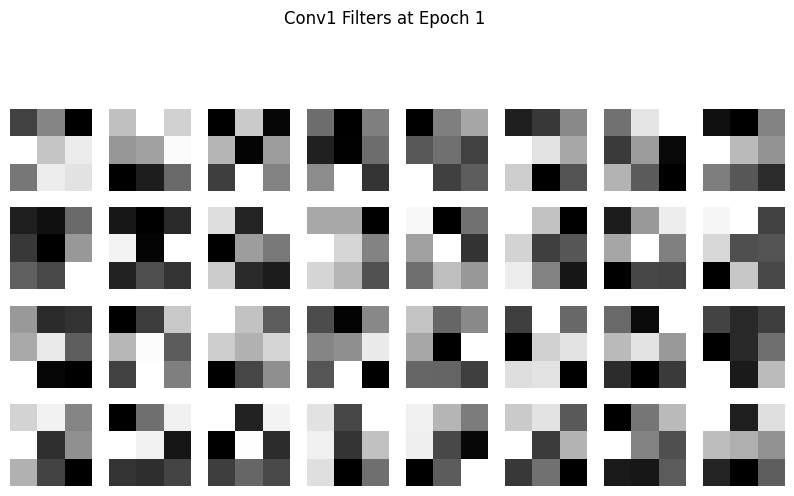

Epoch 2/30: 100%|██████████| 250/250 [00:06<00:00, 38.50it/s, loss=1.49]



Epoch 2 | Train Loss: 1.4662
Validation Loss: 1.4135 | Accuracy: 46.81%



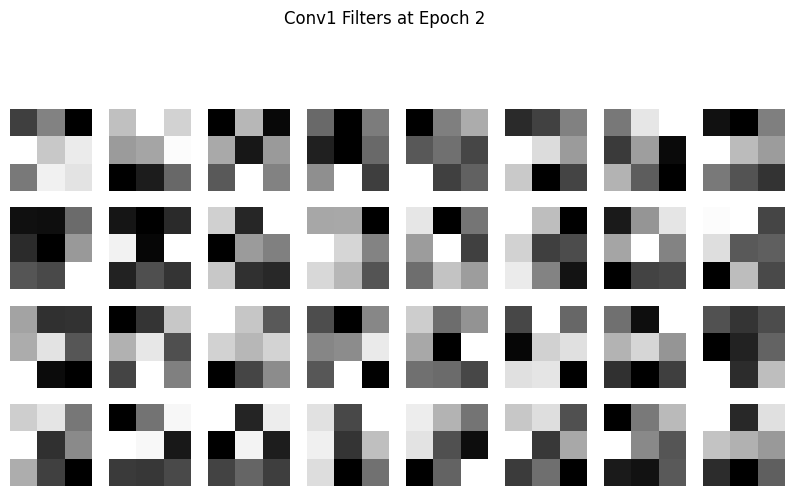

Epoch 3/30: 100%|██████████| 250/250 [00:06<00:00, 38.44it/s, loss=1.37]



Epoch 3 | Train Loss: 1.3816
Validation Loss: 1.3595 | Accuracy: 48.76%



Epoch 4/30: 100%|██████████| 250/250 [00:06<00:00, 38.79it/s, loss=1.2]



Epoch 4 | Train Loss: 1.3351
Validation Loss: 1.2561 | Accuracy: 53.86%



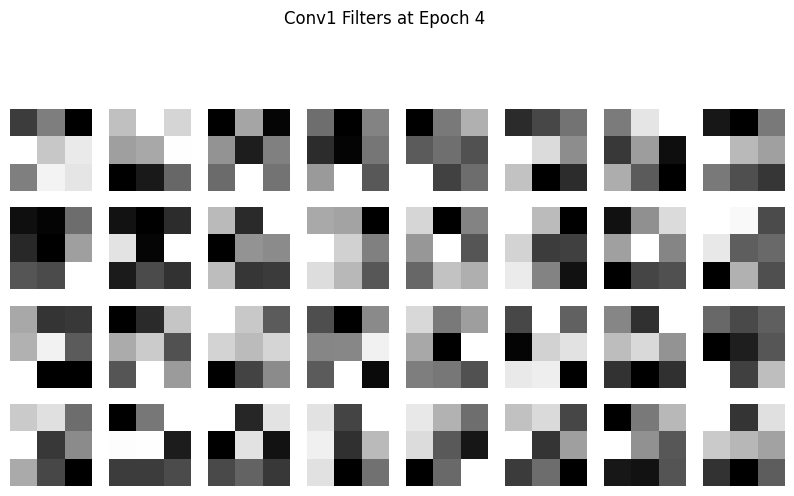

Epoch 5/30: 100%|██████████| 250/250 [00:06<00:00, 38.83it/s, loss=1.13]



Epoch 5 | Train Loss: 1.3017
Validation Loss: 1.2153 | Accuracy: 55.46%



Epoch 6/30: 100%|██████████| 250/250 [00:06<00:00, 38.06it/s, loss=1.38]



Epoch 6 | Train Loss: 1.2539
Validation Loss: 1.1990 | Accuracy: 56.55%



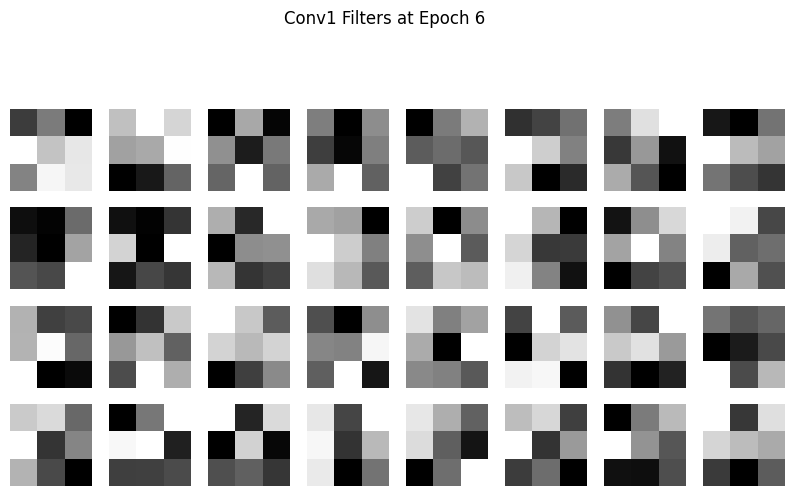

Epoch 7/30: 100%|██████████| 250/250 [00:06<00:00, 35.98it/s, loss=1.05]



Epoch 7 | Train Loss: 1.2293
Validation Loss: 1.1683 | Accuracy: 57.50%



Epoch 8/30: 100%|██████████| 250/250 [00:06<00:00, 36.95it/s, loss=1.08]



Epoch 8 | Train Loss: 1.1941
Validation Loss: 1.1122 | Accuracy: 59.41%



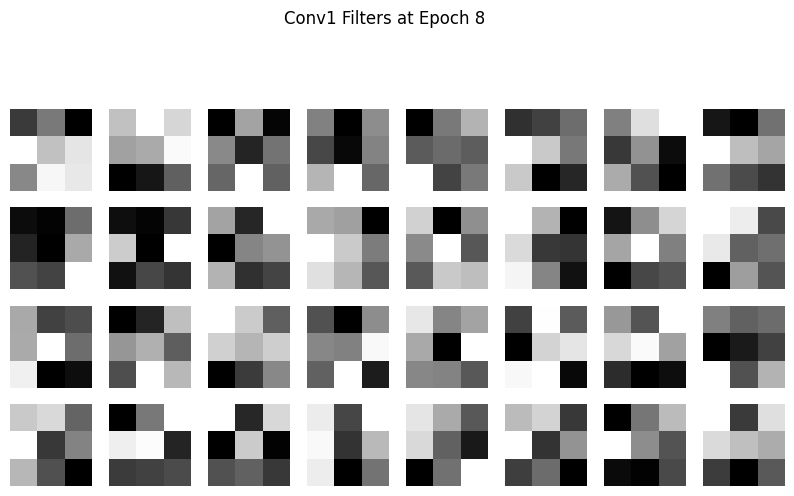

Epoch 9/30: 100%|██████████| 250/250 [00:06<00:00, 36.07it/s, loss=1.03]



Epoch 9 | Train Loss: 1.1671
Validation Loss: 1.1340 | Accuracy: 58.51%



Epoch 10/30: 100%|██████████| 250/250 [00:06<00:00, 36.88it/s, loss=1.27]



Epoch 10 | Train Loss: 1.1401
Validation Loss: 1.1461 | Accuracy: 58.61%



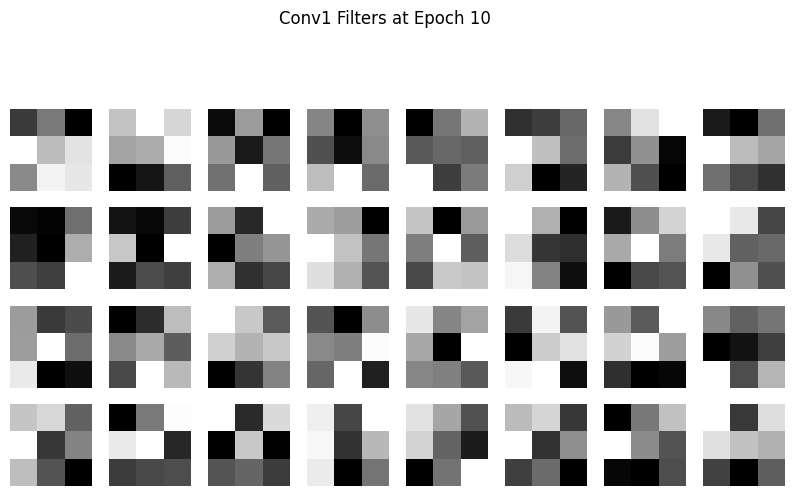

Epoch 11/30: 100%|██████████| 250/250 [00:06<00:00, 38.31it/s, loss=1.17]



Epoch 11 | Train Loss: 1.1273
Validation Loss: 1.1140 | Accuracy: 59.59%



Epoch 12/30: 100%|██████████| 250/250 [00:06<00:00, 38.54it/s, loss=1.11]



Epoch 12 | Train Loss: 1.0999
Validation Loss: 1.0601 | Accuracy: 61.80%



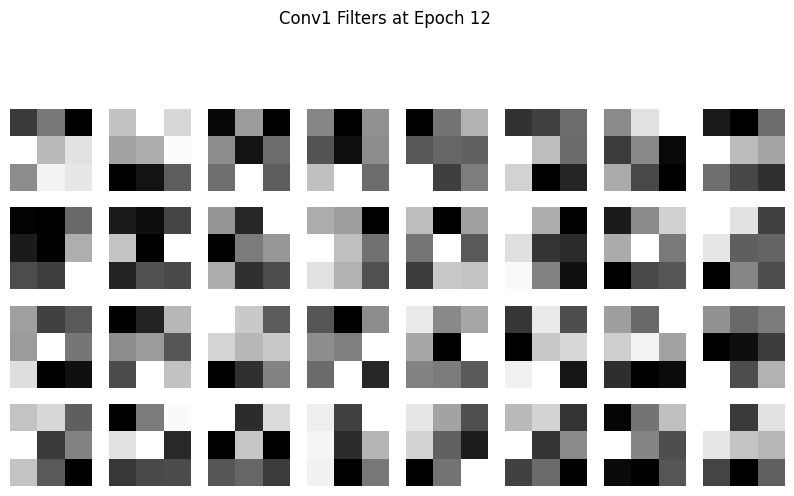

Epoch 13/30: 100%|██████████| 250/250 [00:06<00:00, 38.61it/s, loss=0.901]



Epoch 13 | Train Loss: 1.0775
Validation Loss: 1.0785 | Accuracy: 61.32%



Epoch 14/30: 100%|██████████| 250/250 [00:06<00:00, 38.31it/s, loss=0.985]



Epoch 14 | Train Loss: 1.0509
Validation Loss: 1.0464 | Accuracy: 63.11%



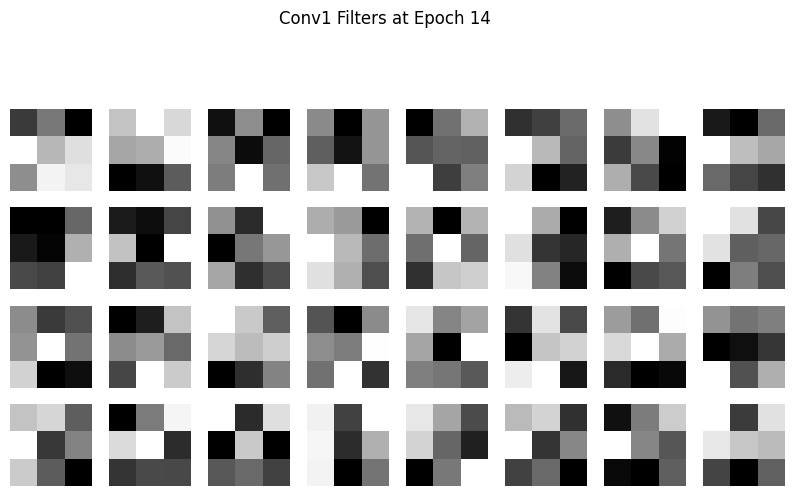

Epoch 15/30: 100%|██████████| 250/250 [00:06<00:00, 36.81it/s, loss=1.06]



Epoch 15 | Train Loss: 1.0240
Validation Loss: 1.0400 | Accuracy: 61.91%



Epoch 16/30: 100%|██████████| 250/250 [00:07<00:00, 35.50it/s, loss=0.997]



Epoch 16 | Train Loss: 1.0091
Validation Loss: 1.0184 | Accuracy: 63.70%



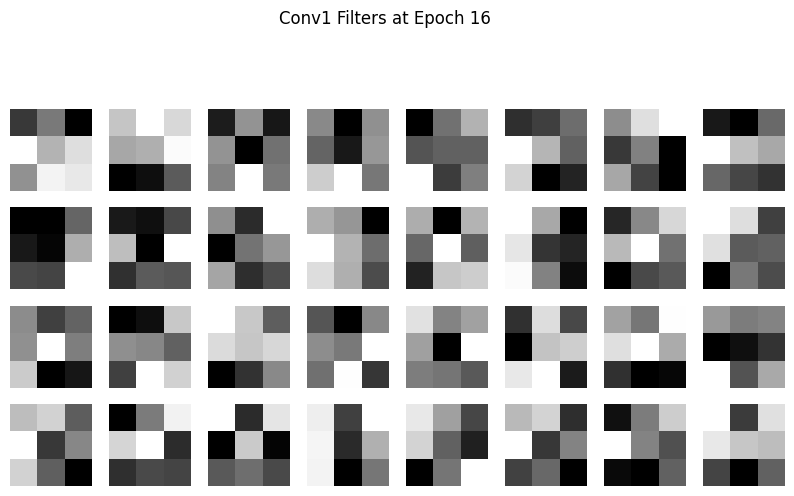

Epoch 17/30: 100%|██████████| 250/250 [00:07<00:00, 35.66it/s, loss=1.05]



Epoch 17 | Train Loss: 0.9918
Validation Loss: 1.0157 | Accuracy: 63.99%



Epoch 18/30: 100%|██████████| 250/250 [00:06<00:00, 36.09it/s, loss=0.652]



Epoch 18 | Train Loss: 0.9961
Validation Loss: 1.0201 | Accuracy: 63.68%



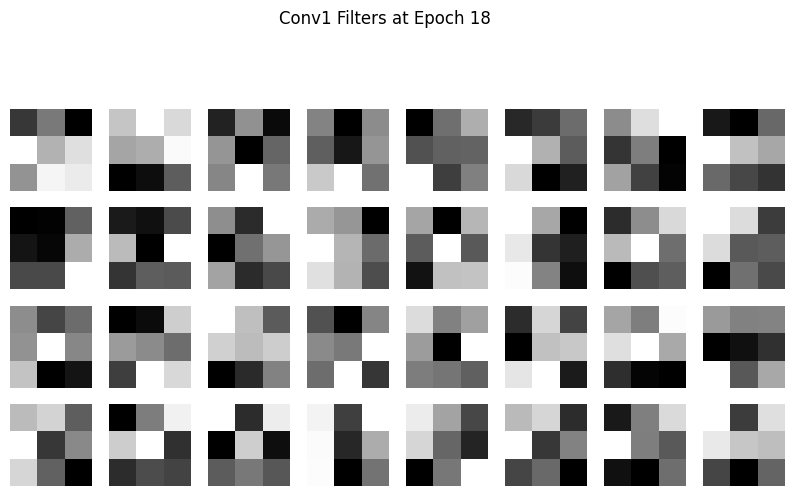

Epoch 19/30: 100%|██████████| 250/250 [00:07<00:00, 35.15it/s, loss=0.84]



Epoch 19 | Train Loss: 0.9603
Validation Loss: 1.0050 | Accuracy: 64.19%



Epoch 20/30: 100%|██████████| 250/250 [00:06<00:00, 36.94it/s, loss=1.1]



Epoch 20 | Train Loss: 0.9499
Validation Loss: 1.0390 | Accuracy: 63.46%



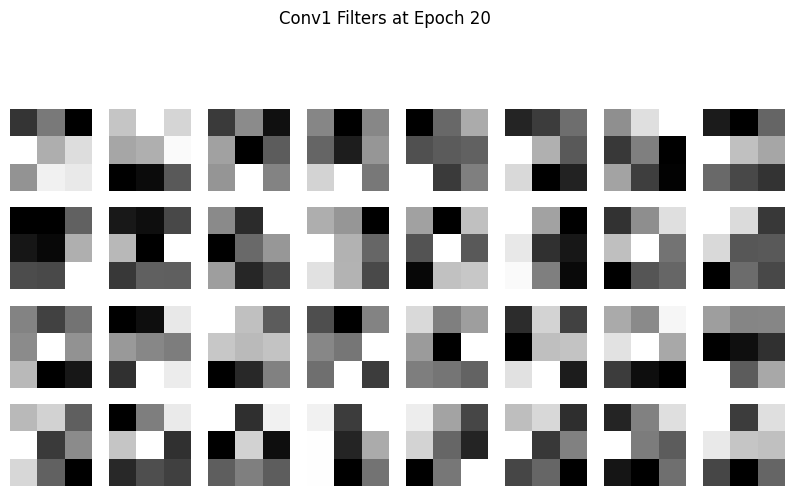

Epoch 21/30: 100%|██████████| 250/250 [00:06<00:00, 37.35it/s, loss=0.87]



Epoch 21 | Train Loss: 0.9304
Validation Loss: 1.0451 | Accuracy: 63.85%



Epoch 22/30: 100%|██████████| 250/250 [00:06<00:00, 37.74it/s, loss=0.755]



Epoch 22 | Train Loss: 0.9270
Validation Loss: 1.0545 | Accuracy: 63.12%



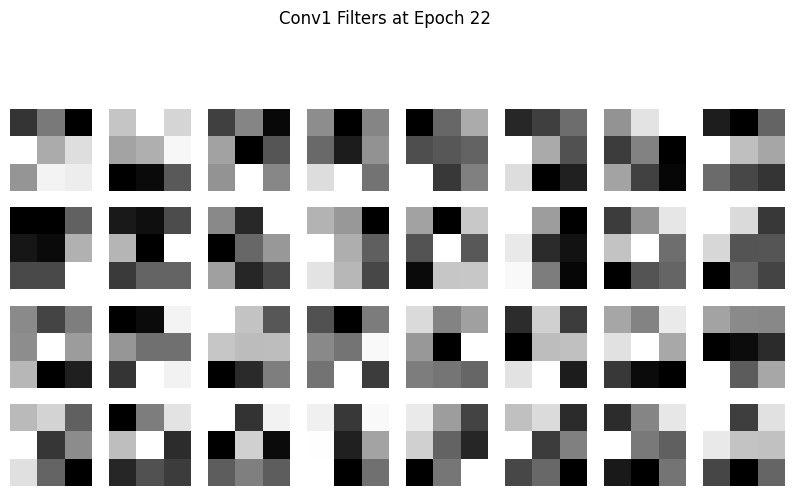

Epoch 23/30: 100%|██████████| 250/250 [00:06<00:00, 36.09it/s, loss=0.878]



Epoch 23 | Train Loss: 0.9032
Validation Loss: 0.9920 | Accuracy: 65.56%



Epoch 24/30: 100%|██████████| 250/250 [00:06<00:00, 37.14it/s, loss=1.13]



Epoch 24 | Train Loss: 0.8885
Validation Loss: 1.0024 | Accuracy: 64.98%



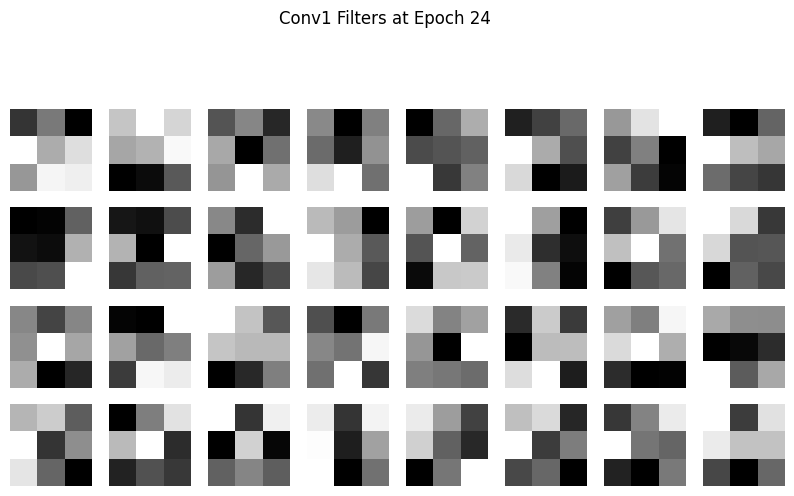

Epoch 25/30: 100%|██████████| 250/250 [00:06<00:00, 36.31it/s, loss=0.681]



Epoch 25 | Train Loss: 0.8696
Validation Loss: 1.0164 | Accuracy: 65.20%



Epoch 26/30: 100%|██████████| 250/250 [00:07<00:00, 34.65it/s, loss=0.625]



Epoch 26 | Train Loss: 0.8598
Validation Loss: 1.0414 | Accuracy: 64.41%



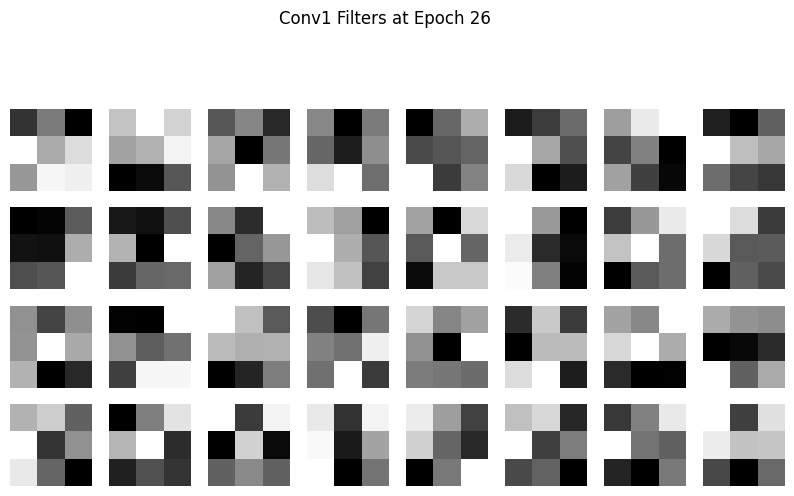

Epoch 27/30: 100%|██████████| 250/250 [00:07<00:00, 33.94it/s, loss=1.21]



Epoch 27 | Train Loss: 0.8516
Validation Loss: 1.0505 | Accuracy: 64.76%



Epoch 28/30: 100%|██████████| 250/250 [00:07<00:00, 34.16it/s, loss=1.03]



Epoch 28 | Train Loss: 0.8384
Validation Loss: 1.0535 | Accuracy: 64.71%



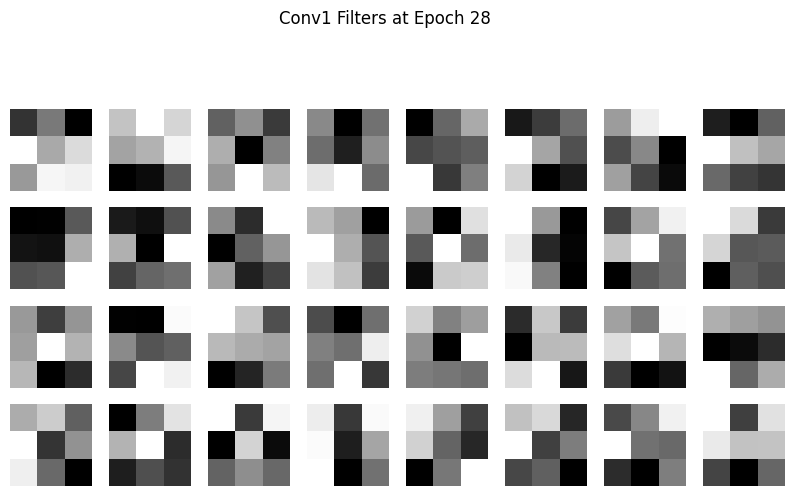

Epoch 29/30: 100%|██████████| 250/250 [00:07<00:00, 33.13it/s, loss=0.676]



Epoch 29 | Train Loss: 0.8296
Validation Loss: 1.0349 | Accuracy: 65.79%



Epoch 30/30: 100%|██████████| 250/250 [00:07<00:00, 33.83it/s, loss=0.965]



Epoch 30 | Train Loss: 0.8063
Validation Loss: 1.0340 | Accuracy: 65.26%



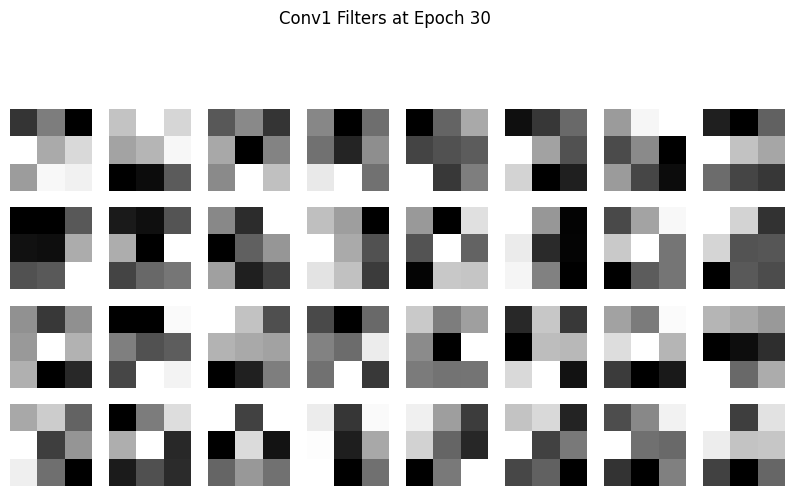

DeepCNN_BN_Dropout3(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.2, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.3, inplace=False)
  (global_pool): AdaptiveAvgPool2d(output_size=(4, 4))
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Line

In [33]:
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm  # For real-time progress tracking

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3 = DeepCNN_BN_Dropout3().to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model3.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Training loop
num_epochs = 30

for epoch in range(num_epochs):
    model3.train()
    total_loss = 0

    # Use tqdm for progress tracking
    loop = tqdm(combined_dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=True)

    for X, y in loop:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()

        # Use model3 for forward pass
        outputs = model3(X)
        loss = criterion(outputs, y)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Update progress bar with loss
        loop.set_postfix(loss=loss.item())

    avg_train_loss = total_loss / len(combined_dataloader)
    print(f"\nEpoch {epoch+1} | Train Loss: {avg_train_loss:.4f}")

    # **Validation Checkpoint After Each Epoch**
    model3.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            # Use model3 for validation
            outputs = model3(X)
            loss = criterion(outputs, y)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y).sum().item()

    avg_test_loss = test_loss / len(test_dataloader)
    accuracy = correct / len(test_dataloader.dataset)

    print(f"Validation Loss: {avg_test_loss:.4f} | Accuracy: {accuracy * 100:.2f}%\n")

    # **Visualize Filters and Feature Maps**
    if epoch == 0 or (epoch + 1) % 2 == 0:  # Every 2 epochs
        with torch.no_grad():
            # Access filters from model3
            filters = model3.conv1.weight.cpu().numpy()

        plt.figure(figsize=(10, 10))
        for i in range(min(32, filters.shape[0])):  # Handle filter count dynamically
            plt.subplot(8, 8, i+1)
            plt.imshow(filters[i, 0, :, :], cmap='gray')
            plt.axis('off')
        plt.suptitle(f"Conv1 Filters at Epoch {epoch+1}")
        plt.show()

# Final Test Evaluation (Use model3)
model3.eval()
# ... (rest of the evaluation code using model3) ...

Training in with model3 which has a combined data set of unlabelled and labeled images shows that with every epoch, the validation accuracy was improving. Increasing the number of epochs has potential of improving perfomance of this model.

In [34]:
#Step 9 Save model
torch.save(model3.state_dict(), "model3.pth")


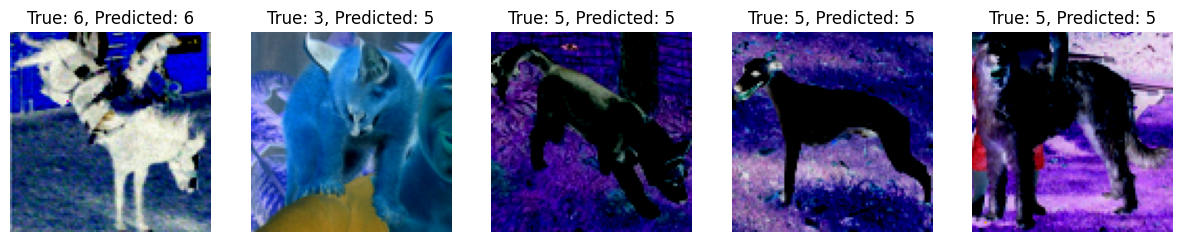

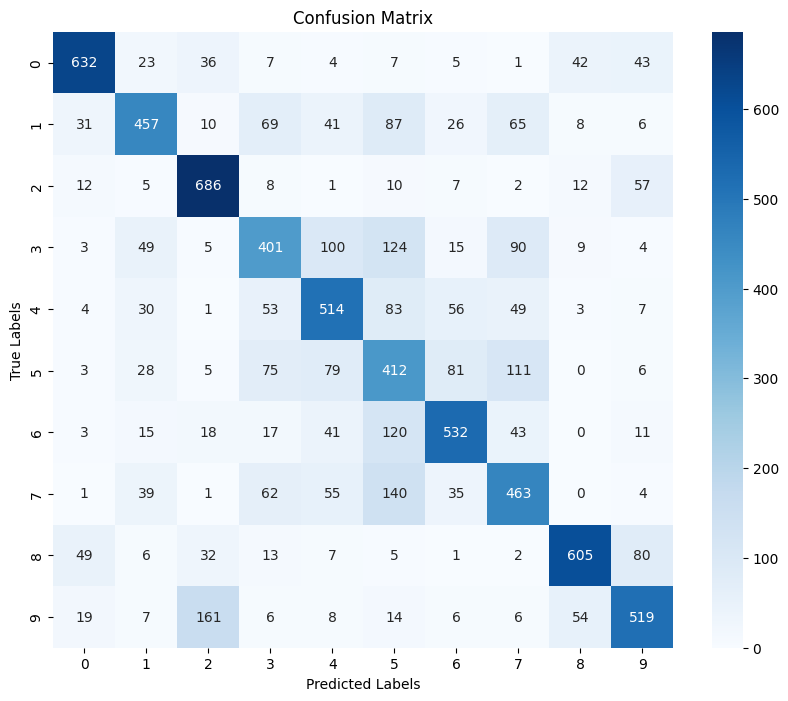

In [35]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns  # Import seaborn for heatmap

# Assuming model3 is trained and loaded
model3.eval()

# Make predictions on the test data
all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model3(images)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Plot sample images with predictions
num_samples = 5
fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

for i in range(num_samples):
    index = np.random.randint(len(test_dataset))
    image, label = test_dataset[index]
    image = image.permute(1, 2, 0)  # Reorder dimensions for plotting
    prediction = all_predictions[index]

    axes[i].imshow(image)
    axes[i].set_title(f"True: {label}, Predicted: {prediction}")
    axes[i].axis("off")

plt.show()

# Create and display the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Using seaborn for a better visualization
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

The confusionmatrix shows that most of the labels are largel predicted correctly although label 9 is sometimes predicted as label 2 with 161 images which belong to the label 9 class incorrectly predicted as 2. This was also common with label 7 which was wrongly predicted 140 times to belong to the label 5 class. Label 2 class is enjoys the highest accurate predictions with 686 images accurately predicted and with only 57 images incorrectly predicted as belonging to the label 9 class.

Out of the sample predictions plotted, Label 5 class is the only wrongly predicted class. Overally, combining the labeled dats set and the unlabeled dataset has potential of improving perfomance of this model. The model was initially trained on he labeled dataset however, after combining the data set, some accurate predictions are being made on the unlabeled dataset.

Conclusion
The unlabeled dataset can be used to avoid the model from overfitting during training, in as much as predictions will not be made on the unlabeled data set.